**Datasets**

In [343]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
import cv2

In [348]:
#Concatenate LQ, MQ, HQ

suffix = ".csv"
csv_directory = "Datasets/"
csv_files = [i for i in os.listdir(csv_directory) if i.endswith( suffix )]

full_data = []
for i in range(len(csv_files)):
    data = pd.read_csv(csv_directory+'/'+csv_files[i], sep=';', index_col = 0)
    full_data.append(data)

full_data = pd.concat(full_data, axis=0)
print(full_data.shape)
full_data.head(25)



full_data =  pd.read_csv('Datasets/HQ_digital.csv', sep=';', index_col = 0)
full_data = full_data.replace("X", 10)

full_data.head()

(858, 6)


,used_liter,image,cadran_1,cadran_2,cadran_3,cadran_4
0,33,e104664ba1792dde641d87cd5d95f1df06786140.jpg,10,10,3,3
1,29,48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg,10,10,2,9
2,230,9e111802446b62b86aeffe911415ad28227caba7.jpg,10,2,3,0
3,43,f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg,10,10,4,3
4,51,62e96bf40409b3b6fd74065ab0bf3ec44f9d0a61.jpg,10,10,5,1


In [349]:
#Only use data for which we have images

frame_directory = "Datasets_frames/"

data = full_data[full_data["image"].isin(os.listdir(frame_directory))]
print(data.shape)
data.head(40)

(200, 6)


,used_liter,image,cadran_1,cadran_2,cadran_3,cadran_4
0,33,e104664ba1792dde641d87cd5d95f1df06786140.jpg,10,10,3,3
1,29,48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg,10,10,2,9
2,230,9e111802446b62b86aeffe911415ad28227caba7.jpg,10,2,3,0
3,43,f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg,10,10,4,3
5,238,c836ea17748e562c99f93edc51f2b900664ec37d.jpg,10,2,3,8
7,211,ad09efeb3fb287283c6674797b9214313d12b5f1.jpg,10,2,1,1
8,51,87e827d58b36c7921568b270eae938e677c97207.jpg,10,10,5,1
9,29,fdddffcd1423ea0366eb81802ce1351bccf6dcaa.jpg,10,10,2,9
11,81,2b6481132ed176928dfeefd11f7b10b56b49d517.jpg,10,10,8,1
12,202,fbd02b4f1eac089a9af1a9e0a24e888e3226d6bc.jpg,10,2,0,2


**Split into test and validation sets**

In [350]:
from sklearn.cross_validation import train_test_split

X = data.iloc[:,1]
y = data.iloc[:,2:]

ids_train, ids_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [351]:
y_train_vect = [y_train["cadran_1"], y_train["cadran_2"], y_train["cadran_3"], y_train["cadran_4"]]
y_val_vect =  [y_val["cadran_1"], y_val["cadran_2"], y_val["cadran_3"], y_val["cadran_4"]]

**Convert to arrays**

In [352]:
def convert_to_arrays(samples, directory):
    X = []
    for sample in samples:
        ID =  directory + "%s" % (sample)
        img = Image.open(ID)
        img = np.array(img)
        img = cv2.equalizeHist(img)
        img = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY_INV)[1]
        img = cv2.dilate(img, None, iterations=1)
        img = img[:,:245]
        img = img.reshape((img.shape[0],img.shape[1],1))
        X.append(img)
    X = np.asarray(X)
    return X

X_train = convert_to_arrays(ids_train, frame_directory)
X_val = convert_to_arrays(ids_val, frame_directory)

**CNN Model**

In [353]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers.core import Dropout, Activation
from keras.layers import BatchNormalization
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras import regularizers
import keras.backend
import tensorflow as tf


session_config = tf.ConfigProto()
session_config.gpu_options.visible_device_list = "0"
session_config.gpu_options.allow_growth = True
set_session(tf.Session(config=session_config))


model_input = Input((100,245,1))

x = Conv2D(32, (3, 3), padding='same', name='conv2d_hidden_1', kernel_regularizer=regularizers.l2(0.01))(model_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(3, 3),name='maxpool_2d_hidden_1')(x)
x = Dropout(0.30)(x)

x = Conv2D(64, (3, 3), padding='same', name='conv2d_hidden_2', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(3, 3),name='maxpool_2d_hidden_2')(x)
x = Dropout(0.30)(x)

x = Conv2D(128, (3, 3), padding='same', name='conv2d_hidden_3', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(3, 3),name='maxpool_2d_hidden_3')(x)
x = Dropout(0.30)(x)

x = Flatten()(x)

x = Dense(256, activation ='relu', kernel_regularizer=regularizers.l2(0.01))(x)

digit1 = (Dense(output_dim =11,activation = 'softmax', name='digit_1'))(x)
digit2 = (Dense(output_dim =11,activation = 'softmax', name='digit_2'))(x)
digit3 = (Dense(output_dim =11,activation = 'softmax', name='digit_3'))(x)
digit4 = (Dense(output_dim =11,activation = 'softmax', name='digit_4'))(x)

outputs = [digit1, digit2, digit3, digit4]

M = Model(input = model_input , output = outputs)
M._make_predict_function()

opt = Adam(lr=0.001, decay=0.0001)

M.compile(loss="sparse_categorical_crossentropy", optimizer= opt, metrics = ['accuracy'])

keras.backend.get_session().run(tf.initialize_all_variables())

history =M.fit(X_train, y_train_vect, batch_size= 50, nb_epoch=10, verbose=1, validation_data=(X_val, y_val_vect))

/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="digit_1", units=11)`
/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="digit_2", units=11)`
/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="digit_3", units=11)`
/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="digit_4", units=11)`
/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/home/aamomeni/anaconda3/lib/python3.6

Train on 150 samples, validate on 50 samples
Epoch 1/10
150/150 [==============================] - 12s 80ms/step - loss: 19.0892 - digit_1_loss: 0.8260 - digit_2_loss: 3.6168 - digit_3_loss: 4.3738 - digit_4_loss: 4.1258 - digit_1_acc: 0.6933 - digit_2_acc: 0.3800 - digit_3_acc: 0.1133 - digit_4_acc: 0.1200 - val_loss: 14.0749 - val_digit_1_loss: 4.1485e-05 - val_digit_2_loss: 1.1453 - val_digit_3_loss: 3.5791 - val_digit_4_loss: 3.2091 - val_digit_1_acc: 1.0000 - val_digit_2_acc: 0.6000 - val_digit_3_acc: 0.2000 - val_digit_4_acc: 0.1200
Epoch 2/10
150/150 [==============================] - 0s 1ms/step - loss: 17.9025 - digit_1_loss: 1.0729e-06 - digit_2_loss: 1.3438 - digit_3_loss: 5.2951 - digit_4_loss: 5.1263 - digit_1_acc: 1.0000 - digit_2_acc: 0.4667 - digit_3_acc: 0.1133 - digit_4_acc: 0.0733 - val_loss: 13.5445 - val_digit_1_loss: 1.3234e-05 - val_digit_2_loss: 0.6588 - val_digit_3_loss: 3.8581 - val_digit_4_loss: 2.9019 - val_digit_1_acc: 1.0000 - val_digit_2_acc: 0.8000 - val

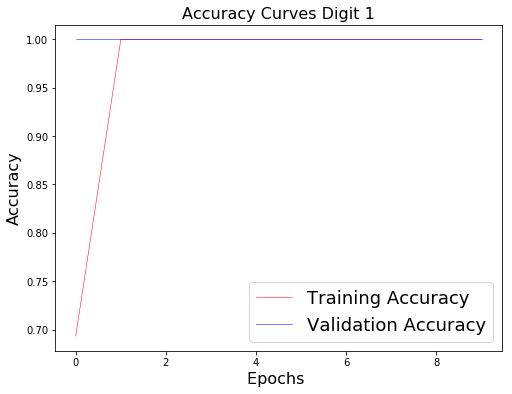

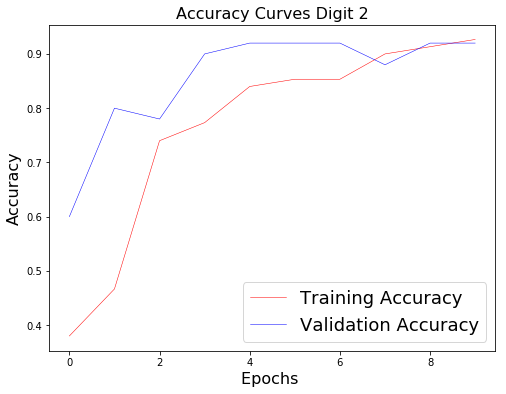

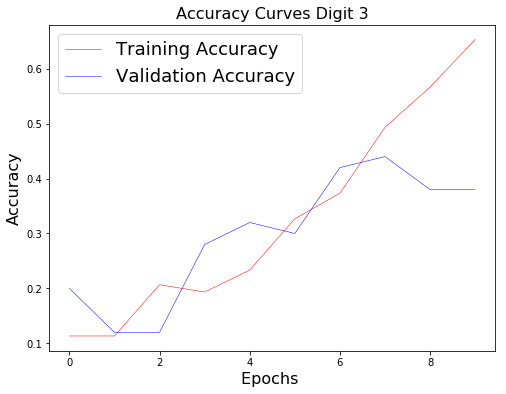

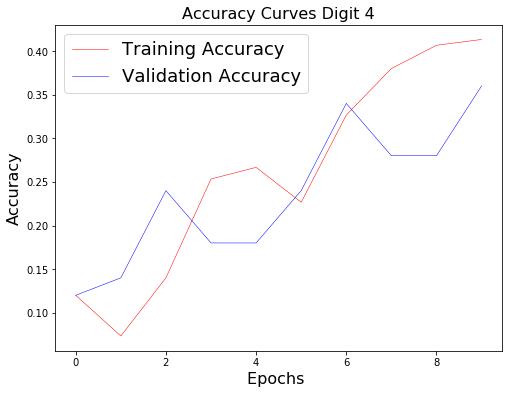

In [363]:
# Acc Curves

for i in range(1,5):
        plt.figure(figsize=[8,6])
        plt.plot(history.history['digit_%i_acc' %i],'r',linewidth=0.5)
        plt.plot(history.history['val_digit_%i_acc' %i],'b',linewidth=0.5)
        plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
        plt.xlabel('Epochs ',fontsize=16)
        plt.ylabel('Accuracy',fontsize=16)
        plt.title('Accuracy Curves Digit %i' %i,fontsize=16)
        plt.show()


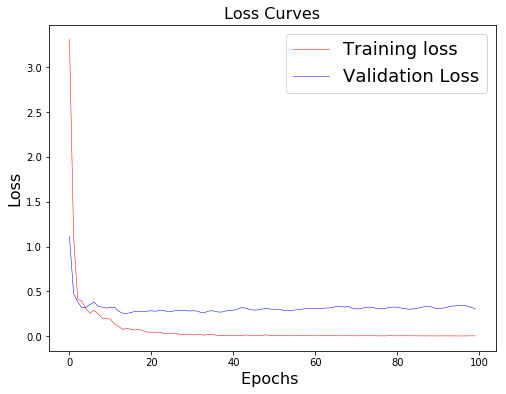

In [247]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['digit_2_loss'],'r',linewidth=0.5)
plt.plot(history.history['val_digit_2_loss'],'b',linewidth=0.5)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

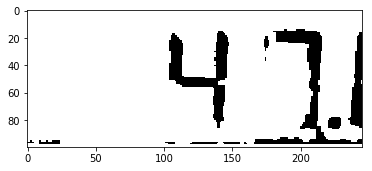

In [248]:
ID = 'Datasets_frames/08d21828339e1a6adcd892ef2f0d0866083c51bf.jpg'
img = Image.open(ID)
img = np.array(img)
img = cv2.equalizeHist(img)
img = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY_INV)[1]
img = cv2.dilate(img, None, iterations=1)
img = img[:,:245]
plt.imshow(img, cmap=plt.cm.gray)
plt.show()


In [249]:
img = img.reshape((1,img.shape[0],img.shape[1],1))
preds = M.predict(img)

In [250]:
for i in range(len(preds)):
    print(np.argmax(preds[i]))

10
10
4
7


In [251]:
y_pred = M.predict(X_val)

In [257]:
correct_preds = 0

for i in range(X_val.shape[0]):         
    pred_list_i = [np.argmax(pred[i]) for pred in y_pred]
    val_list_i  = y_val.values[i].astype('int')
    if np.array_equal(val_list_i, pred_list_i):
        correct_preds = correct_preds + 1

        
mse = 0 
diff = []


for i in range(X_val.shape[0]):
        pred_list_i = [np.argmax(pred[i]) for pred in y_pred]
        pred_number = 1000* pred_list_i[0] + 100* pred_list_i[1] + 10 * pred_list_i[2] + 1* pred_list_i[3]
        val_list_i  = y_val.values[i].astype('int')
        val_number = 1000* val_list_i[0] + 100*  val_list_i[1] + 10 *  val_list_i[2] + 1*  val_list_i[3]
        diff.append(val_number - pred_number)
        

np.sort(diff)
        
        
    

array([-909, -834,  -81,  -61,  -54,  -41,  -40,  -38,  -25,  -15,   -8,
         -6,   -6,   -6,   -5,   -4,   -3,   -2,   -2,   -1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    1,    1,
          2,    3,    3,    4,    6,    6,    7,   10,   10,   11,   20,
         30,  829])

In [ ]:
val_list_i  = [val[i] for val in y_val]
    matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
    correct_preds = int(np.all(matching_preds))

total_acc = (correct_preds / float(X_test.shape[0]))*100
print(total_acc)

**MNIST Model**

In [376]:
ids = []
labels = []
for i in range(11):
    directory = 'Datasets_digits/%i/' %i
    for j in os.listdir(directory):
        if j != '.DS_S':
            ids.append(directory+j)
            labels.append(i)

data = pd.DataFrame(list(zip(ids,labels)))

data.head()

,0,1
0,Datasets_digits/0/9254cdb3e6d79badf7aeed697338...,0
1,Datasets_digits/0/0454db70b35aec40367b67904783...,0
2,Datasets_digits/0/846136278e66e5431f21403ca750...,0
3,Datasets_digits/0/2358d7e0201150737631f45cfd74...,0
4,Datasets_digits/0/631887ed74c7390a6e2c81d5c11a...,0


In [377]:
ids = []
labels = []
for i in range(10):
    directory = 'Datasets_Eleven/%i/' %i
    for j in os.listdir(directory):
        ids.append(directory+j)
        labels.append(i)
data = pd.DataFrame(list(zip(ids,labels)))
data.head()

,0,1
0,Datasets_Eleven/0/01cbb4e0a7fd47251fc1340aa9df...,0
1,Datasets_Eleven/0/01cbb4e0a7fd47251fc1340aa9df...,0
2,Datasets_Eleven/0/02b292a500dfb9192379fe830534...,0
3,Datasets_Eleven/0/02b292a500dfb9192379fe830534...,0
4,Datasets_Eleven/0/04dc6be4599a36518fcb26bf9355...,0


In [378]:
X = data.iloc[:,0]
y = data.iloc[:,1]

ids_train, ids_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

def convert_digits_to_arrays(samples):
    X = []
    for sample in samples:
        img = Image.open(sample)
        img = np.array(img)
        #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img.resize((30,50))
        img = cv2.equalizeHist(img)
        img = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY_INV)[1]
        img = cv2.dilate(img, None, iterations=1)
        img = np.array(img)
        img = img.reshape((30,50,1))
        X.append(img)
    X = np.asarray(X)
    return X

X_train = convert_digits_to_arrays(ids_train)
X_val = convert_digits_to_arrays(ids_val)

In [379]:
model_input = Input((30,50,1))

x = Conv2D(32, (3, 3), padding='same', name='conv2d_hidden_1', kernel_regularizer=regularizers.l2(0.01))(model_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(3, 3),name='maxpool_2d_hidden_1')(x)
x = Dropout(0.30)(x)

x = Conv2D(63, (3, 3), padding='same', name='conv2d_hidden_2', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(3, 3),name='maxpool_2d_hidden_2')(x)
x = Dropout(0.30)(x)

x = Conv2D(128, (3, 3), padding='same', name='conv2d_hidden_3', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(3, 3),name='maxpool_2d_hidden_3')(x)
x = Dropout(0.30)(x)

x = Flatten()(x)

x = Dense(1024, activation ='relu', kernel_regularizer=regularizers.l2(0.01))(x)

output = Dense(output_dim =11,activation = 'softmax', name='output')(x)

M = Model(input = model_input , output = output)

opt = Adam(lr=0.001)

M.compile(loss="sparse_categorical_crossentropy", optimizer= opt, metrics = ['accuracy'])

history = M.fit(X_train, y_train, batch_size= 32, nb_epoch=30, verbose=1, validation_data=(X_val, y_val))

/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="output", units=11)`
/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
/home/aamomeni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 167 samples, validate on 56 samples
Epoch 1/30
167/167 [==============================] - 42s 251ms/step - loss: 7.5173 - acc: 0.2994 - val_loss: 7.1023 - val_acc: 0.5357
Epoch 2/30
167/167 [==============================] - 0s 1ms/step - loss: 6.9599 - acc: 0.4012 - val_loss: 6.3029 - val_acc: 0.6429
Epoch 3/30
167/167 [==============================] - 0s 1ms/step - loss: 6.2520 - acc: 0.6527 - val_loss: 5.9904 - val_acc: 0.6964
Epoch 4/30
167/167 [==============================] - 0s 946us/step - loss: 5.8353 - acc: 0.7186 - val_loss: 5.5180 - val_acc: 0.8036
Epoch 5/30
167/167 [==============================] - 0s 1ms/step - loss: 5.5350 - acc: 0.7365 - val_loss: 5.2462 - val_acc: 0.7679
Epoch 6/30
167/167 [==============================] - 0s 1ms/step - loss: 5.1969 - acc: 0.7784 - val_loss: 4.9854 - val_acc: 0.7679
Epoch 7/30
167/167 [==============================] - 0s 1ms/step - loss: 4.9601 - acc: 0.8084 - val_loss: 4.7502 - val_acc: 0.8571
Epoch 8/30
167/167 [======

In [380]:
y_pred = M.predict(X_val)

e = []
for i in range(X_val.shape[0]):
    val_id = ids_val.values[i]
    pred_list_i = np.argmax(y_pred[i]).astype('int')
    val_list_i  = y_val.values[i].astype('int')
    if val_list_i != pred_list_i:
        e.append(val_id.split('/')[2].split('-')[0])
np.unique(e)
#        print(val_id, pred_list_i, val_list_i)

array(['3c823ec6e7a7405211c7d9281432a406929eff97 ',
       '7f3858530e5bfb01f3b76aeadb4a01212d53f0fe '], dtype='<U41')

In [374]:
val_id.split('/')[2].split('-')[0]

'8ecb0b9d2fba086caf434b7a4864434f9ea0da0e '

AttributeError: 'numpy.ndarray' object has no attribute 'split'